In [494]:
import pandas as pd
import numpy as np
import altair as alt

#pip install vega
#jupyter nbextension install --sys-prefix --py vega

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [3]:
import requests

host = 'http://localhost:8080/api'
stream = 'demo-event-store'

def run_test(count):
    query = { "batchSize": count }
    response = requests.request('GET', f'{host}/sys-info/performance/measure/event-store/insert-events/{count}', params=query)
    return response.json()

def clear_stream():
    response = requests.request('DELETE', f'{host}/event-store/streams/{stream}/events')
    token = response.json()
    response = requests.request('POST', f'{host}/event-store/clear-request-confirmation', json=token)
    return response

In [412]:
import datetime
import pandas as pd

def run_tests(counts=[1,100], trials_per_count=1, env_info={}):
    now = datetime.datetime.now().replace(microsecond=0).isoformat().replace(':', '-')
    csv_name = f'results-{now}.csv'
    
    env_info_columns = list(env_info.keys())
    
    df = pd.DataFrame(columns = [*env_info_columns, 'buffer_size_in_bytes', 'event_count', 'trial', 'duration_in_ms', 'measured_on'])
    
    for count in counts:
        for i in range(0, trials_per_count):
            print(f'Trial {i+1} for event count {count}')
            results = run_test(count)
            print(results['message'])       
            df = df.append({
                **env_info,
                'buffer_size_in_bytes': results['bufferSize'], 
                'trial': i+1, 
                'event_count': count, 
                'duration_in_ms': results['timeElapsed'],                 
                'measured_on': now
            }, ignore_index=True)
            df.to_csv(f'measurements/{csv_name}', index=False)                 
            # clean service after each trial. Must delete all events to avoid OOO
            stream_cleared = clear_stream()
            print(stream_cleared)            
            
    return df

In [26]:
clear_stream()

<Response [200]>

In [495]:
env_info = {
    'cluster_type': 'localI7', 
    'node_count': 3, 
    'event_type': 'randomized', 
    'buffer_type': 'none'
}

run_tests(counts=[1, 100, 10000, 1000000], trials_per_count=10, env_info=env_info)

# run_tests(counts=[10000000], trials_per_count=10, env_info=env_info)

# an event of our examples has ~21 bytes

In [23]:
# TODO we actually don't know how long the insert is in total as we are async as soon as events are offered to the buffer-
# So, as we are waiting for buffer flushes, but not the last flush, we miss the time it tooks to apply the last flushed buffer
# TODO therefore need some callback in event store to know when the store is done, not just the buffer...
# example: Inserted events 10000 times asynchronously [45ms] <-- this is just the time it takes to insert them into the in-mem buffer!
# -> at least 4.5 sec for 1mio events to put into the buffer

# -> raft log entry size is limited! ->  # Log entry size 13383315 exceeds the max buffer limit of 4194304
# raft.server.log.appender.buffer.byte-limit = 4MB

In [ ]:
# TODO test on non-replicated chronicle db and compare

In [ ]:
# TODO test with maximum size buffer

In [ ]:
# TODO test with raft log entries not persisted

In [415]:
# load all measurements

from os import walk

resource_folder = 'measurements'

resources = next(walk(resource_folder), (None, None, []))[2]

print(f'{len(resources)} files in total')

12 files in total


In [416]:
datasets = {filename: pd.read_csv(f'{resource_folder}/{filename}', sep=',', encoding='utf-8', error_bad_lines=False) for filename in resources}

In [427]:
all_measurements_df = pd.concat(datasets, ignore_index=True)

all_measurements_df

cluster_type  node_count  event_type buffer_type  buffer_size_in_bytes  \
0        localI7           3  randomized    blocking                 10240   
1        localI7           3  randomized    blocking                 10240   
2        localI7           3  randomized    blocking                 10240   
3        localI7           3  randomized    blocking                 10240   
4        localI7           3  randomized    blocking                 10240   
..           ...         ...         ...         ...                   ...   
398      localI7           3  randomized        none                     0   
399      localI7           3  randomized        none                     0   
400      localI7           3  randomized        none                     0   
401      localI7           3  randomized        none                     0   
402      localI7           3  randomized        none                     0   

     event_count  trial  duration_in_ms          measured_on  
0              1      1               1  2022-01-29T12-48-43  
1              1      2               0  2022-01-29T12-48-43  
2              1      3               2  2022-01-29T12-48-43  
3              1      4               0  2022-01-29T12-48-43  
4              1      5               1  2022-01-29T12-48-43  
..           ...    ...             ...                  ...  
398        10000      6          203265  2022-01-30T11-33-05  
399        10000      7          223869  2022-01-30T11-33-05  
400        10000      8          202324  2022-01-30T11-33-05  
401        10000      9          222241  2022-01-30T11-33-05  
402        10000     10          224618  2022-01-30T11-33-05  

[403 rows x 9 columns]

In [428]:
# supress warnings
pd.options.mode.chained_assignment = None

# remove rows with duration = 0 to avoid divide by zero
all_measurements_df = all_measurements_df[all_measurements_df['duration_in_ms'] > 0]

# replace buffer_size 0 with 1 to allow log scale plotting
all_measurements_df.loc[all_measurements_df['buffer_size_in_bytes'] == 0, 'buffer_size_in_bytes'] = 1

all_measurements_df['duration_per_event'] = all_measurements_df['duration_in_ms'] / all_measurements_df['event_count']
all_measurements_df['duration_per_mio_events'] = all_measurements_df['duration_per_event'] * 1000000
all_measurements_df['duration_per_mio_events_in_sec'] = all_measurements_df['duration_per_mio_events'] / 1000
all_measurements_df['events_per_second'] = 1000 / all_measurements_df['duration_per_event']

pd.options.mode.chained_assignment = 'warn'

all_measurements_df.describe()

node_count  buffer_size_in_bytes   event_count       trial  \
count       362.0          3.620000e+02  3.620000e+02  362.000000   
mean          3.0          3.759523e+05  5.359369e+05    5.395028   
std           0.0          4.816229e+05  1.655205e+06    2.918330   
min           3.0          1.000000e+00  1.000000e+00    1.000000   
25%           3.0          1.024000e+03  1.000000e+02    3.000000   
50%           3.0          1.024000e+05  1.000000e+04    5.000000   
75%           3.0          1.048576e+06  1.000000e+06    8.000000   
max           3.0          1.048576e+06  1.000000e+07   10.000000   

       duration_in_ms  duration_per_event  duration_per_mio_events  \
count      362.000000          362.000000             3.620000e+02   
mean     26720.618785            2.318804             2.318804e+06   
std      86401.635993            7.688223             7.688223e+06   
min          1.000000            0.002300             2.300000e+03   
25%          3.000000            0.010348             1.034825e+04   
50%         85.500000            0.021062             2.106150e+04   
75%      10025.500000            0.480987             4.809870e+05   
max     485271.000000           86.000000             8.600000e+07   

       duration_per_mio_events_in_sec  events_per_second  
count                      362.000000         362.000000  
mean                      2318.803975       65088.545015  
std                       7688.222628       85534.153706  
min                          2.300000          11.627907  
25%                         10.348250        2079.061847  
50%                         21.061500       47480.105258  
75%                        480.987000       96635.499579  
max                      86000.000000      434782.608696

In [435]:
import altair as alt

def plot_event_rate(df, title="Event Throughput Rates"):    
    buffer_size_label_expr = "datum.label && datum.label[0] == '1' ? (datum.value >= 1000000 ? datum.value / 1000000 + ' MB' : datum.value >= 1000 ? datum.value / 1000 + ' KB' : datum.label + ' B') : null"    

    blocking_queue_event_rate_plot = alt.Chart(df).mark_bar(clip=True, width=15).encode(
        x=alt.X('buffer_size_in_bytes:Q', scale=alt.Scale(type='log'), title="Buffer Size (in Bytes, Log Scale)", axis=alt.Axis(        
            labelExpr=buffer_size_label_expr
        )),
        y=alt.Y('median(events_per_second):Q', title="Median of Events/sec", scale=alt.Scale(padding=1))
    ).properties(width=300, title=title)

    return blocking_queue_event_rate_plot + blocking_queue_event_rate_plot.mark_text(
        align='right',
        color='black',
        dx=-12,
        dy=8
    ).encode(
        text=alt.Text('median(events_per_second):Q', format=',.0f')
    ).transform_calculate(label='datum.y + " inches"')

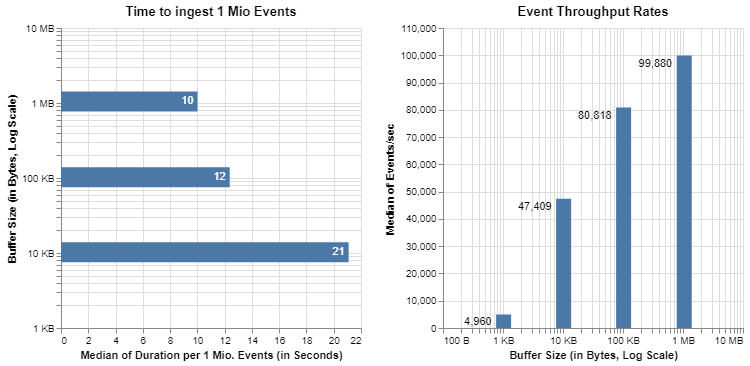

In [496]:
buffer_size_label_expr = "datum.label && datum.label[0] == '1' ? (datum.value >= 1000000 ? datum.value / 1000000 + ' MB' : datum.value >= 1000 ? datum.value / 1000 + ' KB' : datum.label + ' B') : null"

duration_plot = alt.Chart(all_measurements_df[all_measurements_df['buffer_size_in_bytes'] > 1048]).mark_bar(clip=True, height=20).encode(
    x=alt.X('median(duration_per_mio_events_in_sec):Q', title="Median of Duration per 1 Mio. Events (in Seconds)"),
    y=alt.Y('buffer_size_in_bytes:Q', scale=alt.Scale(type='log'), title="Buffer Size (in Bytes, Log Scale)", axis=alt.Axis(        
        labelExpr=buffer_size_label_expr
    )),
).properties(width=300, title="Time to ingest 1 Mio Events")

duration_plot = duration_plot + duration_plot.mark_text(
    align='right',
    color='white',
    dx=-4,
    #dy=-18
).encode(
    text=alt.Text('median(duration_per_mio_events_in_sec):Q', format=',.0f'),
)

duration_plot | plot_event_rate(all_measurements_df[all_measurements_df['buffer_size_in_bytes'] > 1])

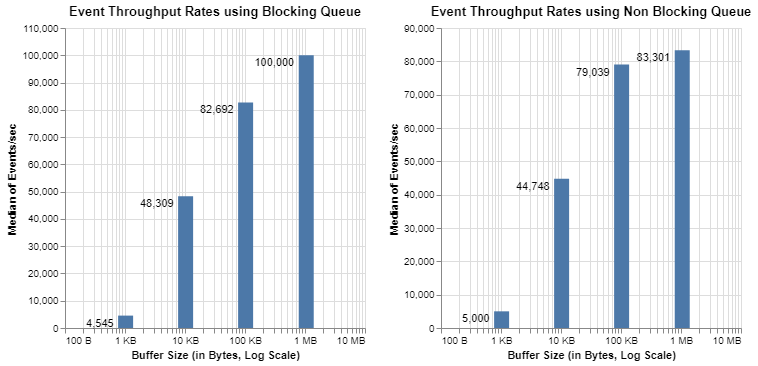

In [497]:
blocking_queue_df = all_measurements_df[all_measurements_df['buffer_type'] == 'blocking']
non_blocking_queue_df = all_measurements_df[all_measurements_df['buffer_type'] == 'non-blocking']

plot_event_rate(blocking_queue_df, title="Event Throughput Rates using Blocking Queue") | plot_event_rate(non_blocking_queue_df, title="Event Throughput Rates using Non Blocking Queue")

## TODO measure standalone chronicleDB!

## TODO DEBS data

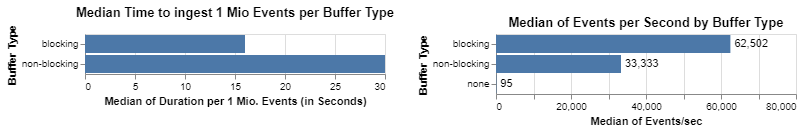

In [498]:
buffered_measurements_df = all_measurements_df[all_measurements_df['buffer_type'] != 'none']

time_per_buffer_plot = alt.Chart(buffered_measurements_df).mark_bar(clip=True).encode(
    x=alt.X('median(duration_per_mio_events_in_sec):Q', title="Median of Duration per 1 Mio. Events (in Seconds)"),
    y=alt.Y('buffer_type:N',title="Buffer Type"),
).properties(width=300, title="Median Time to ingest 1 Mio Events per Buffer Type")

events_per_sec_plot = alt.Chart(all_measurements_df).mark_bar(clip=True).encode(
    x=alt.X('median(events_per_second):Q', title="Median of Events/sec", scale=alt.Scale(domain=[0, 80000])),
    y=alt.Y('buffer_type:N',title="Buffer Type"),
).properties(width=300, title="Median of Events per Second by Buffer Type")


events_per_sec_plot = events_per_sec_plot + events_per_sec_plot.mark_text(
    align='left',
    color='black',
    dx=4,
    #dy=-18
).encode(
    text=alt.Text('median(events_per_second):Q', format=',.0f'),
)

time_per_buffer_plot | events_per_sec_plot

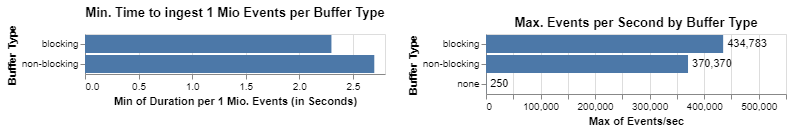

In [499]:
time_per_buffer_plot = alt.Chart(buffered_measurements_df).mark_bar(clip=True).encode(
    x=alt.X('min(duration_per_mio_events_in_sec):Q', title="Min of Duration per 1 Mio. Events (in Seconds)"),
    y=alt.Y('buffer_type:N',title="Buffer Type"),
).properties(width=300, title="Min. Time to ingest 1 Mio Events per Buffer Type")

events_per_sec_plot = alt.Chart(all_measurements_df).mark_bar(clip=True).encode(
    x=alt.X('max(events_per_second):Q', title="Max of Events/sec", scale=alt.Scale(domain=[0, 550000])),
    y=alt.Y('buffer_type:N',title="Buffer Type"),
).properties(width=300, title="Max. Events per Second by Buffer Type")


events_per_sec_plot = events_per_sec_plot + events_per_sec_plot.mark_text(
    align='left',
    color='black',
    dx=4,
    #dy=-18
).encode(
    text=alt.Text('max(events_per_second):Q', format=',.0f'),
)

time_per_buffer_plot | events_per_sec_plot

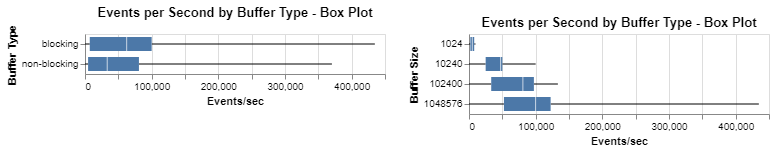

In [500]:
alt.Chart(buffered_measurements_df).mark_boxplot(extent='min-max').encode(
    y=alt.Y('buffer_type:N',title="Buffer Type"),
    x=alt.X('events_per_second:Q', title="Events/sec"),    
).properties(width=300, title="Events per Second by Buffer Type - Box Plot") | alt.Chart(buffered_measurements_df).mark_boxplot(extent='min-max').encode(
    y=alt.Y('buffer_size_in_bytes:O',title="Buffer Size"),
    x=alt.X('events_per_second:Q', title="Events/sec"),    
).properties(width=300, title="Events per Second by Buffer Type - Box Plot")

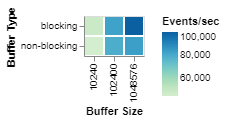

In [501]:
alt.Chart(all_measurements_df[all_measurements_df['buffer_size_in_bytes'] > 1024]).mark_bar(clip=True).encode(
    color=alt.Color('median(events_per_second):Q', title="Events/sec", scale=alt.Scale(scheme='greenblue')),
    x=alt.X('buffer_size_in_bytes:N',title="Buffer Size"),
    y=alt.Y('buffer_type:N',title="Buffer Type"),
).properties(title="")

Running the cluster without a buffer leads to 100% utilization of the machines IO, as in the current naive implementation of the raft log and state machine, each event is sent to all nodes, needs to be committed by at least a quorum of notes and is also written into the raft log of each node.

In [ ]:
# TODO compare with paper